In [ ]:
import pandas as pd
import numpy as np
import math
from scipy.stats import entropy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
import warnings
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv('VAW.csv')

print("Columns in dataset:", data.columns.tolist())

# Preprocessing
data.columns = data.columns.to_series().apply(lambda x: x.split(':')[0].strip())

if 'OUTCOME' not in data.columns:
    raise KeyError("The column 'OUTCOME' is missing from the dataset!")

data['OUTCOME'] = data['OUTCOME'].replace('Any', np.nan)

print("Unique OUTCOME values:", data['OUTCOME'].unique())

def injectNaN(x):
    if x == "_T":
        return np.nan
    else:
        return x

for col in data.columns:
    try:
        data[col] = data[col].apply(lambda x: x.split(':')[0])
        data[col] = data[col].apply(injectNaN)
    except AttributeError:
        pass

#Drop columns where entropy > 60%
dropList = []
threshold = 0.6

for col in data.columns:
    ent = entropy(data[col].value_counts())
    missing_percentage = data[col].isnull().sum() / len(data)
    if ent == 0 or missing_percentage > threshold:
        if col != 'OUTCOME':
            dropList.append(col)
            print(f'Column "{col}" entropy: {ent:.2f} || Missing: {missing_percentage:.2%} || ADDED TO DROPLIST')

data.drop(dropList, axis=1, inplace=True)

def printDFInfo(df):
    for col in df.columns:
        ent = entropy(df[col].value_counts())
        print(f'Column "{col}"\tΜissing values: {(df[col].isnull().sum() * 100 / len(df[col])):.2f}% || Entropy: {ent:.3f}')

printDFInfo(data)

# Train and test split
data_train = data[data['OUTCOME'].notna()]
data_test = data[data['OUTCOME'].isna()]

print(f"Train Data Shape: {data_train.shape}")
print(f"Test Data Shape: {data_test.shape}")
printDFInfo(data_train)
printDFInfo(data_test)

#Hndling Missing Values with the application of Iterative Imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=42)
num_cols = data_train.select_dtypes(include=['number']).columns

data_train[num_cols] = imputer.fit_transform(data_train[num_cols])
data_test[num_cols] = imputer.transform(data_test[num_cols])

cat_cols = data_train.select_dtypes(include=['object']).columns.drop('OUTCOME', errors='ignore')

#Handling missing values on categorical variables with SimpleImputer
cat_imputer = SimpleImputer(strategy="most_frequent")

data_train[cat_cols] = cat_imputer.fit_transform(data_train[cat_cols])
data_test[cat_cols] = cat_imputer.transform(data_test[cat_cols])

#Encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data_train[cat_cols] = encoder.fit_transform(data_train[cat_cols])
data_test[cat_cols] = encoder.transform(data_test[cat_cols])

scaler = StandardScaler()
data_train[num_cols] = scaler.fit_transform(data_train[num_cols])
data_test[num_cols] = scaler.transform(data_test[num_cols])

# Split
X_train = data_train.drop(columns=['OUTCOME'])
y_train = data_train['OUTCOME']
X_test = data_test.drop(columns=['OUTCOME'])



Columns in dataset: ['DATAFLOW', 'FREQ: Frequency', 'TIME_PERIOD: Time', 'GEO_PICT: Pacific Island Countries and territories', 'TOPIC: Topic', 'INDICATOR: Indicator', 'SEX: Sex', 'AGE: Age', 'CONDITION: Women’s condition', 'VIOLENCE_TYPE: Type of violence', 'PERPETRATOR: Perpetrator', 'ACTUALITY: Actuality', 'LIFEPER: Period of life', 'OUTCOME: Outcome', 'RESPONSE: Response', 'HELP_REASON: Reason for searching help', 'HELP_PROVIDER: Help provider', 'OBS_VALUE', 'UNIT_MEASURE: Unit of measure', 'UNIT_MULT: Unit multiplier', 'OBS_STATUS: Observation Status', 'DATA_SOURCE: Data source', 'OBS_COMMENT: Comment']
Unique OUTCOME values: ['_T: Any' 'INJ: Injured' 'LOSCONS: Lost consciousness'
 'HURT: Hurt enough to need health care'
 'EMODIST: Symptoms of emotional distress in the past 4 weeks'
 'HEALTHAFF: Affected their health'
 'HEALTHSTA: Fair or poorer health status' 'PAIN: Pain'
 'PROBMEM: Problems with memory or concentrating'
 'PROBUSUAL: problems with performing usual activities'
 'PR

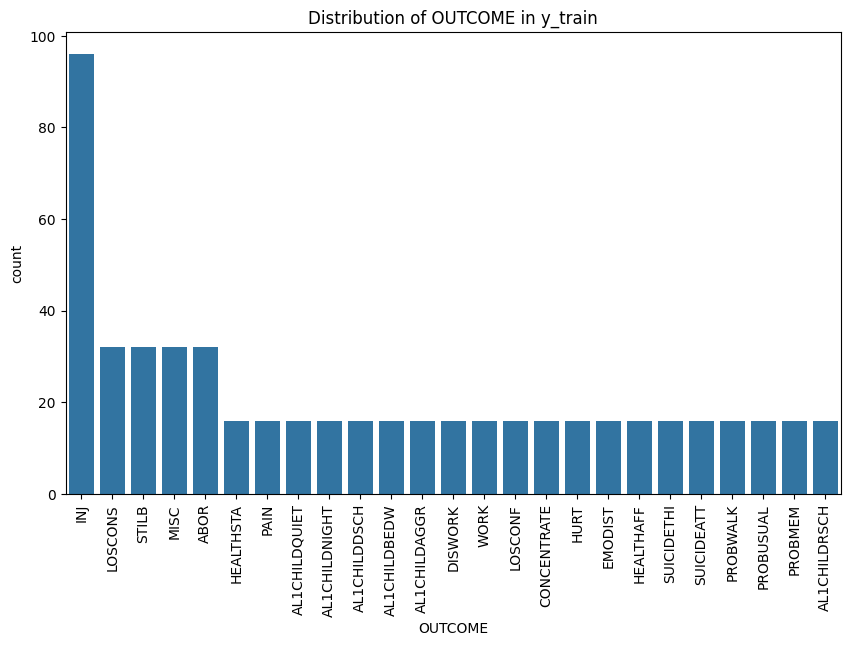

In [ ]:
#target values' distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, order=y_train.value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of OUTCOME in y_train")
plt.show()

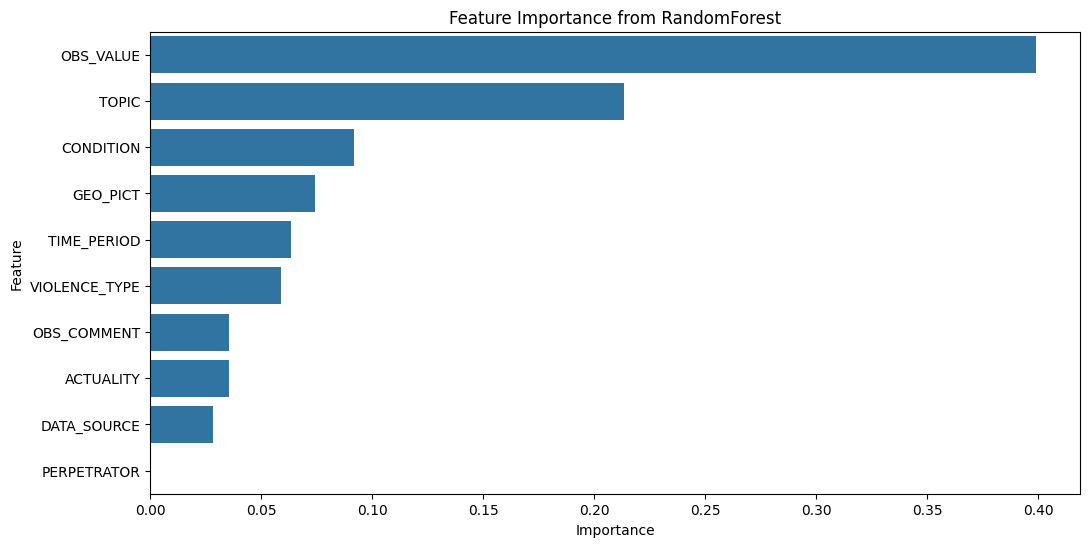

Highly correlated features to remove: []
Number of components selected by PCA: 4
Fitting 3 folds for each of 6 candidates, totalling 18 fits

📌 Best Parameters for KNN Classifier: {'n_neighbors': 3, 'weights': 'distance'}
Balanced Accuracy: 0.7167
Precision: 0.7865
Recall: 0.7167
F1-score: 0.7134
----------------------------------------
Fitting 3 folds for each of 9 candidates, totalling 27 fits

📌 Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Balanced Accuracy: 0.7278
Precision: 0.8034
Recall: 0.7278
F1-score: 0.7363
----------------------------------------
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📌 Best Parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}
Balanced Accuracy: 0.7141
Precision: 0.7258
Recall: 0.7141
F1-score: 0.7159
----------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits

📌 Best Parameters for MLP Classifier: {'activation': 'tanh', 'hidden_layer

In [ ]:
# Feature Importance Analysis using RandomForest
feature_importance_model = RandomForestClassifier(n_estimators=100, random_state=42)
feature_importance_model.fit(X_train, y_train)
importances = feature_importance_model.feature_importances_
feature_names = X_train.columns

# Visualizing feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.title("Feature Importance from RandomForest")
plt.show()

# Keeping only the most important features (e.g., top 80%)
thresh = importance_df['Importance'].quantile(0.2)
selected_features = importance_df[importance_df['Importance'] > thresh]['Feature'].tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Correlation Analysis - Identifying and removing highly correlated features
correlation_matrix = X_train.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

print("Highly correlated features to remove:", high_correlation_features)
X_train.drop(columns=high_correlation_features, inplace=True)
X_test.drop(columns=high_correlation_features, inplace=True)

# PCA for Dimensionality Reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print("Number of components selected by PCA:", pca.n_components_)

#Class imbalance alleviation with SMOTE + Tomek Links application
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

label_encoder = LabelEncoder()
y_train_resampled = label_encoder.fit_transform(y_train_resampled)

#Models definition with balanced class weights
models = {
    "KNN Classifier": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "MLP Classifier": MLPClassifier()
}

# Fine-Tuning
param_grid = {
    "KNN Classifier": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance']
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20]
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.3],
        "n_estimators": [100, 200],
        "max_depth": [3, 6]
    },
    "MLP Classifier": {
        "hidden_layer_sizes": [(50, 50), (100, 100)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "lbfgs"],
        "max_iter": [500]}
}


best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], scoring='balanced_accuracy', cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = grid_search.best_estimator_
    print(f"\n📌 Best Parameters for {name}: {grid_search.best_params_}")
    y_pred = grid_search.best_estimator_.predict(X_train_resampled)
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_train_resampled, y_pred):.4f}")
    print(f"Precision: {precision_score(y_train_resampled, y_pred, average='macro', zero_division=1):.4f}")
    print(f"Recall: {recall_score(y_train_resampled, y_pred, average='macro', zero_division=1):.4f}")
    print(f"F1-score: {f1_score(y_train_resampled, y_pred, average='macro'):.4f}")
    print("-" * 40)

#We keep the best model to make predictions on the data_test
best_model = max(best_models, key=lambda k: balanced_accuracy_score(y_train_resampled, best_models[k].predict(X_train_resampled)))
data_test['OUTCOME'] = best_models[best_model].predict(X_test)

data_test.to_csv("data_test_predicted.csv", index=False)
print("Predictions completed and saved to data_test_predicted.csv.")

#Evaluation of predicted values' distribution
print("\nDistribution of OUTCOME in train set:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

print("\nDistribution of predicted OUTCOME in test set:")
print(data_test['OUTCOME'].value_counts(normalize=True))

